# Test first GAN 
This script heavily uses code from tensorflows pix2pix implementation: https://www.tensorflow.org/tutorials/generative/pix2pix.

If running on hpc clusters, modules like CUDA need to be loaded using the clusters lmod system. 
On the Leipzig University HPC cluster, the respective path is */user/share/lmod*. To use the modules in python, we can run: 

```python
import sys
sys.path.append("/usr/share/lmod/lmod/init")
from env_modules_python import module
module("load", "CUDA")
module("list")
```

like explained here: https://docs.icer.msu.edu/Loading_Modules_in_a_Jupyter_Notebook/.

To get the module path run `module show <module_name>` or in python `module("show","CUDA")`. 

In [1]:
## operating system and cuda setup
import os
# print(os.system("jupyter kernelspec list")) # check available kernels
import sys
sys.path.append("/usr/share/lmod/lmod/init")
from env_modules_python import module
module("load", "CUDA")
module("list")
# Set paths explicitly
os.environ["PATH"] = "/software/easybuild/el8/amd_zen3/all/CUDA/12.6.0/bin:" + os.environ["PATH"]
os.environ["LD_LIBRARY_PATH"] = "/software/easybuild/el8/amd_zen3/all/CUDA/12.6.0/lib:/software/easybuild/el8/amd_zen3/all/CUDA/12.6.0/extras/CUPTI/lib64:/software/easybuild/el8/amd_zen3/all/CUDA/12.6.0/nvvm/lib64:" + os.environ.get("LD_LIBRARY_PATH", "")
os.environ["CUDA_HOME"] = "/software/easybuild/el8/amd_zen3/all/CUDA/12.6.0"
os.environ["CUDA_PATH"] = "/software/easybuild/el8/amd_zen3/all/CUDA/12.6.0"
import subprocess
result = subprocess.run(['nvcc', '--version'], stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
print(result.stdout)
print(result.stderr)
import psutil

## python packages
import pathlib
import time
import datetime
import multiprocessing as mp

## ML packages
import tensorflow as tf

#visualization
from matplotlib import pyplot as plt
from IPython import display
from ipywidgets import widgets


print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

files=os.listdir()
dataset_name = "facades"



Currently Loaded Modules:
  1) CUDA/12.6.0

 




nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Fri_Jun_14_16:34:21_PDT_2024
Cuda compilation tools, release 12.6, V12.6.20
Build cuda_12.6.r12.6/compiler.34431801_0




2025-01-21 17:47:23.550649: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737478043.582261  649234 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737478043.592025  649234 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-21 17:47:23.622713: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Num GPUs Available:  1


Request the dataset

In [2]:
if not ".keras" in files:
    _URL = f'http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/{dataset_name}.tar.gz'

    path_to_zip = tf.keras.utils.get_file(
        fname=f"{dataset_name}.tar.gz",
        origin=_URL,
        extract=True)

    path_to_zip  = pathlib.Path(path_to_zip)

PATH = '.keras/datasets/facades_extracted/facades' #path_to_zip.parent/dataset_name

(256, 512, 3)


I0000 00:00:1737478048.194190  649234 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9617 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:44:00.0, compute capability: 7.5


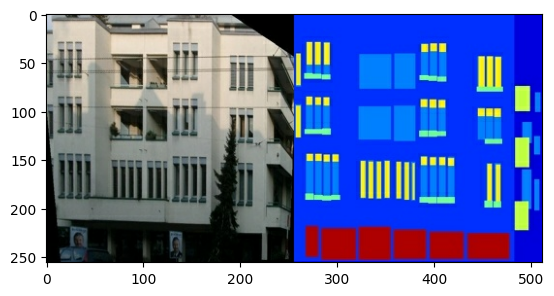

In [3]:
sample_image = tf.io.read_file(os.path.join(PATH, 'train/1.jpg')) # read into tensor type
sample_image = tf.io.decode_jpeg(sample_image) # decode into a 3D tensor (height, width, channels)
print(sample_image.shape) #(height, width, and number of color channels)

plt.figure()
plt.imshow(sample_image)

In [4]:
def load(image_file):
  # Read and decode an image file to a uint8 tensor
  image = tf.io.read_file(image_file)
  image = tf.io.decode_jpeg(image)

  # Split each image tensor into two tensors:
  # - one with a real building facade image
  # - one with an architecture label image 
  w = tf.shape(image)[1]
  w = w // 2
  input_image = image[:, w:, :]
  real_image = image[:, :w, :]

  # Convert both images to float32 tensors
  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

  return input_image, real_image

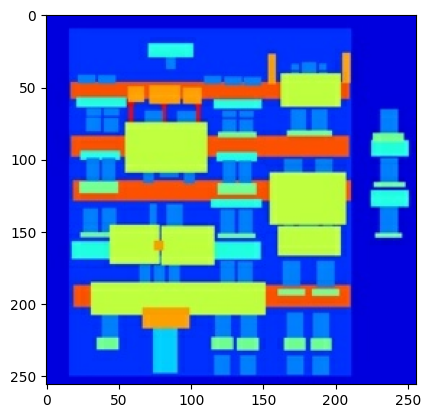

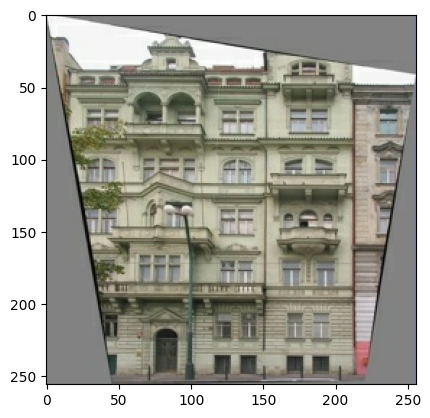

In [5]:
inp, re = load('.keras/datasets/facades_extracted/facades/train/100.jpg')
# Casting to int for matplotlib to display the images
plt.figure()
plt.imshow(inp / 255.0)
plt.figure()
plt.imshow(re / 255.0)

In [6]:
# The facade training set consist of 400 images
BUFFER_SIZE = 400
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 1 # processing one image at a time
# Each image is 256x256 in size
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [7]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

In [8]:
def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

In [9]:
# Normalizing the images to [-1, 1]
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1 #Divide by 127.5 scales the pixel values from ([0, 255]) to ([0, 2]). 
  real_image = (real_image / 127.5) - 1 #Subtracting 1 gives pixel values in the range of ([-1, 1]).

  return input_image, real_image

In [10]:
## jitter is a data augmentation method
## in training machine learning models, particularly in image processing tasks. 
## Data augmentation helps improve the robustness and generalization of the model 
## by applying random transformations to the training images

@tf.function()
def random_jitter(input_image, real_image):
  # Resizing to 286x286
  input_image, real_image = resize(input_image, real_image, 286, 286)

  # Random cropping back to 256x256
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # Random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

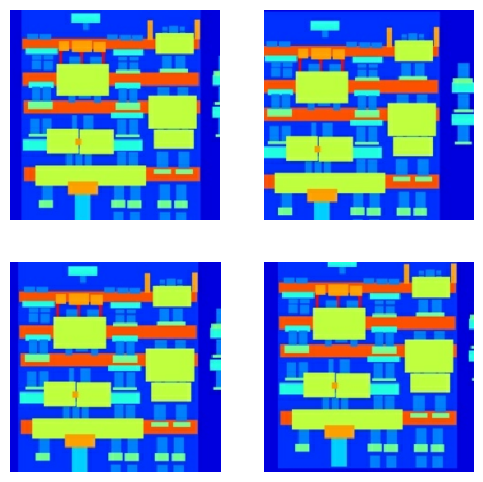

In [11]:
plt.figure(figsize=(6, 6))
for i in range(4):
  rj_inp, rj_re = random_jitter(inp, re)
  plt.subplot(2, 2, i + 1)
  plt.imshow(rj_inp / 255.0)
  plt.axis('off')
plt.show()

In [12]:
def load_image_train(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [13]:
def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [14]:
initPath='.keras/datasets/facades_extracted/facades/'
allImagesPath=os.path.join(initPath,'train/*jpg')
allImagesPath

'.keras/datasets/facades_extracted/facades/train/*jpg'

Load and shuffle dataset

In [15]:
# Create a TensorFlow Dataset from the list of file paths in allImagesPath
train_dataset = tf.data.Dataset.list_files(allImagesPath)
# Map the load_image_train function to each file path in the dataset
# This function will load and preprocess the images
# num_parallel_calls=tf.data.AUTOTUNE allows for parallel processing to improve performance
train_dataset = train_dataset.map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle the dataset with a buffer size
# This helps in mixing the data well during training
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
# Batch the dataset with a batch size
# This groups the data into batches for training
train_dataset = train_dataset.batch(BATCH_SIZE)

In [16]:
try:
  test_dataset = tf.data.Dataset.list_files(os.path.join(initPath,'test/*.jpg'))
except tf.errors.InvalidArgumentError:
  test_dataset = tf.data.Dataset.list_files(os.path.join(initPath,'val/*.jpg'))
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [17]:
OUTPUT_CHANNELS = 3

In [18]:
def downsample(filters, size, apply_batchnorm=True):
    # Initialize the kernel weights (filter weights) with a normal distribution (mean=0.0, stddev=0.02)
    initializer = tf.random_normal_initializer(0., 0.02)

    # Create a Sequential model to stack layers
    result = tf.keras.Sequential()
    
    # Add a Conv2D layer with the specified number of filters and kernel size
    # Stride of 2 for downsampling, 'same' padding to maintain spatial dimensions
    # Kernel weights initialized with the specified initializer, no bias term
    result.add(
        tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                               kernel_initializer=initializer, use_bias=False)
    )

    # If apply_batchnorm is True, add a BatchNormalization layer that normalizes the activations of the previous layer at each batch
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    # Add a LeakyReLU activation layer for non-linearity that allows a small gradient when the unit is not active
    result.add(tf.keras.layers.LeakyReLU())

    # Return the Sequential model
    return result

In [20]:
def upsample(filters, size, apply_dropout=False):
    # Initialize the kernel weights (filter weights) with a normal distribution (mean=0.0, stddev=0.02)
    initializer = tf.random_normal_initializer(0., 0.02)

    # Create a Sequential model to stack layers
    result = tf.keras.Sequential()
    
    # Add a Conv2DTranspose layer with the specified number of filters and kernel size
    # Stride of 2 for upsampling, 'same' padding to maintain spatial dimensions
    # Kernel weights initialized with the specified initializer, no bias term
    # this does a transpose convolution/the opposite the downsample
    result.add(
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                        padding='same',
                                        kernel_initializer=initializer,
                                        use_bias=False)
    )

    # Add a BatchNormalization layer that normalizes the activations of the previous layer at each batch
    result.add(tf.keras.layers.BatchNormalization())

    # If apply_dropout is True, add a Dropout layer with a dropout rate of 0.5 that sets 50% of the input units to 0 at each update during training
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    # Add a ReLU activation layer for non-linearity
    result.add(tf.keras.layers.ReLU())

    # Return the Sequential model
    return result

In [ ]:
# test the downsample and upsample functions
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 256, 256, 3)


In [22]:
def Generator(): # u-net architecture 
  inputs = tf.keras.layers.Input(shape=[256, 256, 3]) # set the input shape (width, height, channels)

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections/residual connections
  # to connect the downsampling and upsampling layers
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [23]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99999905..1.0].


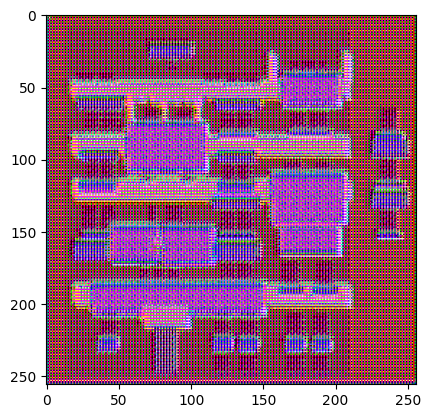

In [24]:
gen_output = generator(inp[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...])

In [27]:
LAMBDA = 100
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True) # binary crossentropy is a loss function used for binary classification tasks

# combined loss function of the generator 
def generator_loss(disc_generated_output, gen_output, target):
  # adversarial loss to encourage the generator to generate realistic images
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output) # compare the generated image to an array of 1s using binary crossentropy

  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

In [28]:
def Discriminator():
  # Initialize the kernel weights (filter weights) with a normal distribution (mean=0.0, stddev=0.02)
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  # Concatenate the input and target images along the channels dimension
  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

  # Downsample the input image to reduce the spatial dimensions
  down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

  # Zero pad the input to make the model symmetric, zero padding is used to add zeros around the border of the image
  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256) 
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  # Apply batch normalization and LeakyReLU activation
  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)
  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  # zero pad to further increase the spatial dimensions
  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  # final convolutional layer that produces the output
  # representing the probability that the input images are real
  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  # return keras Model that takes the input and target images as input
  return tf.keras.Model(inputs=[inp, tar], outputs=last)

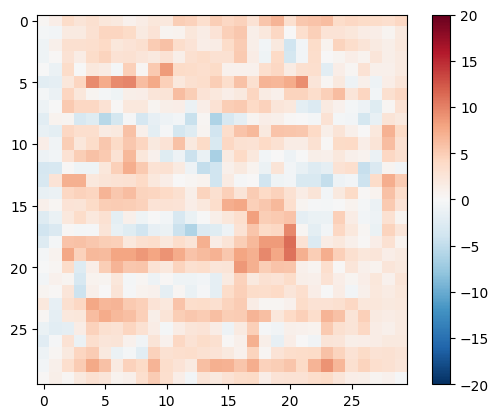

In [29]:
discriminator = Discriminator()
disc_out = discriminator([inp[tf.newaxis, ...], gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

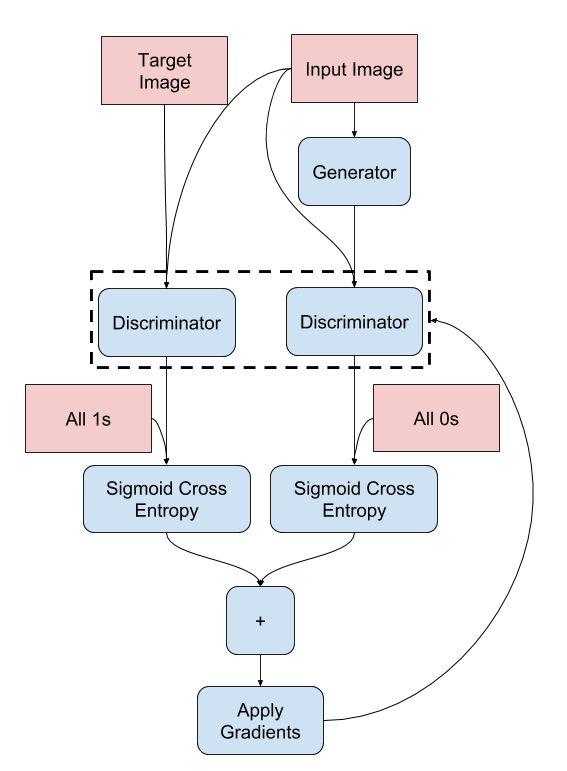

In [30]:
def discriminator_loss(disc_real_output, disc_generated_output):
  
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  #  for real images the target is 1, for generated (fake) images the target is 0
  # zeros_like creates a tensor of zeros with the same shape the disc_generated_output tensor
  # the loss object compares the disc_generated_output tensor to the zeros tensor
  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [31]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [32]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [33]:
def generate_images(model, test_input, tar):
  """
  Function to generate images for the test dataset
  
  Args:
    model: The generator model
    test_input: The input image tensor
    tar: The target image tensor
  """
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

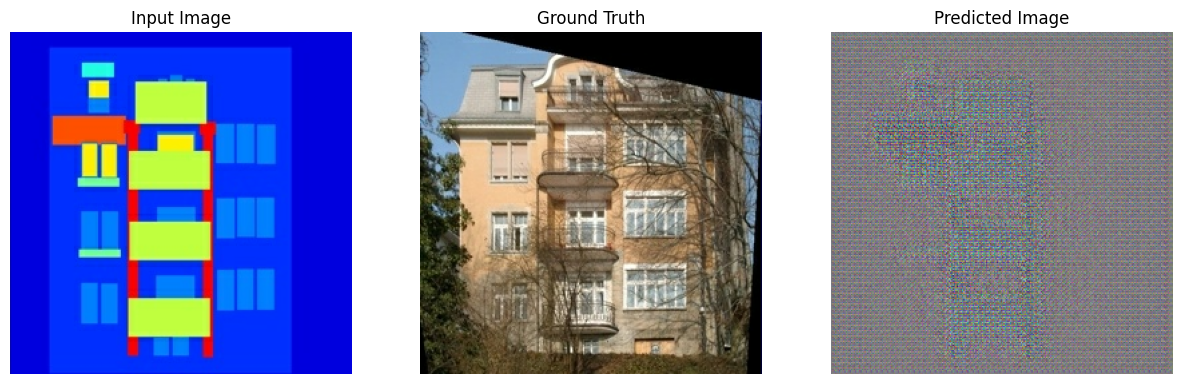

2025-01-21 17:47:42.772537: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [34]:
for example_input, example_target in test_dataset.take(1):
  generate_images(generator, example_input, example_target)

In [35]:
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [36]:
@tf.function
def train_step(input_image, target, step):
  """
  Executes a single training step for the CycleGAN model.
  
  Args:
    input_image: A batch of input images.
    target: A batch of target images.
    step: The current training step.
  """
  # tf.GradientTape() records operations for automatic differentiation / to get the gradient of the loss with respect to the model's trainable variables
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  # Get the gradients
  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  # Apply the gradients to the optimizer
  # this step optimizes the generator and discriminator weights 
  # based on the gradients obtained during the tape recording
  # to minimize the generator and discriminator loss functions
  # by adjusting  the weights based on the computed gradients,
  # the model learns to make better predictions over time 
  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
    tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

In [ ]:
def fit(train_ds, test_ds, steps):
    # Get an example input and target from the test dataset for visualization
    example_input, example_target = next(iter(test_ds.take(1)))
    start = time.time()  # Record the start time

    # Iterate over the training dataset for the specified number of steps
    for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
        # Every 1000 steps, display the progress and generate images
        if (step) % 1000 == 0:
            display.clear_output(wait=True)  # Clear the output for better visualization

            if step != 0:
                # Print the time taken for the last 1000 steps
                print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

            start = time.time()  # Reset the start time

            # Generate and display images using the generator
            generate_images(generator, example_input, example_target)
            print(f"Step: {step//1000}k")

        # Perform a single training step
        train_step(input_image, target, step)

        # Print a dot every 10 steps to show progress
        if (step+1) % 10 == 0:
            print('.', end='', flush=True)

        # Save (checkpoint) the model every 5000 steps
        if (step + 1) % 5000 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

In [38]:
%load_ext tensorboard
%tensorboard --logdir {log_dir}

ERROR: Could not find `tensorboard`. Please ensure that your PATH
contains an executable `tensorboard` program, or explicitly specify
the path to a TensorBoard binary by setting the `TENSORBOARD_BINARY`
environment variable.

Time taken for 1000 steps: 62.05 sec



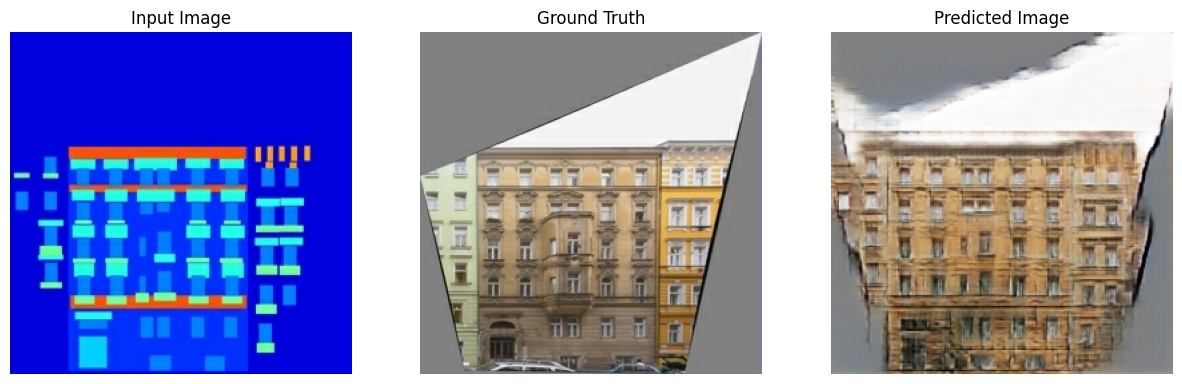

Step: 39k
....................................................................................................

2025-01-21 18:29:47.547274: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
fit(train_dataset, test_dataset, steps=40000) # 40k steps